In [22]:
import os
import h2o
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2ONaiveBayesEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.automl import H2OAutoML

# Carga de datos

In [23]:
df=pd.read_csv("../dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [24]:
df = df.drop(columns=["EmployeeCount", "StandardHours","EmployeeNumber", "Over18"])

In [25]:
# Columns with outliers (6)
cols_robust = [
    'MonthlyIncome', 'NumCompaniesWorked', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

# Categorical columns (19)
cols_categorical = [ 
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
    'JobLevel', 'JobSatisfaction', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',
    'WorkLifeBalance',
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus',
    'OverTime',
]
# Numerical columns (8)
cols_numerical = [
    'Age', 'DailyRate', 'DistanceFromHome',
    'HourlyRate', 'MonthlyRate',
    'PercentSalaryHike', 'TotalWorkingYears'
]

In [26]:
preprocessor = ColumnTransformer(transformers=[
    ('robust', RobustScaler(), list(cols_robust)),
    ('standard', StandardScaler(), list(cols_numerical)),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), list(cols_categorical))
])

In [27]:
# Aplicar transformación
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

X_transformed = preprocessor.fit_transform(X)

# Obtener nombres de columnas codificadas
ohe_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(cols_categorical)
final_feature_names = cols_robust + cols_numerical + list(ohe_names)

# Reconstruir DataFrame
X_processed = pd.DataFrame(X_transformed, columns=final_feature_names)
X_processed["Attrition"] = y.reset_index(drop=True)

### MODELADO

In [28]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,26 mins 50 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 15 days
H2O_cluster_name:,H2O_from_python_Administrador_kx33pf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.597 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [46]:
hf = h2o.H2OFrame(X_processed)
hf["Attrition"] = hf["Attrition"].asfactor()  # Convertir la clase objetivo

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
train, test = hf.split_frame(ratios=[0.8], seed=123)
x = hf.columns[:-1]  # todas menos Attrition
y = "Attrition"


## Regresion Logistica

In [48]:
glm = H2OGeneralizedLinearEstimator(family="binomial", lambda_search=True, seed=123)
glm.train(x=x, y=y, training_frame=train)

print("Regresión Logística")
glm.model_performance(test_data=test).show()


glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Regresión Logística


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.08324610488399463
RMSE: 0.2885240109314901
LogLoss: 0.2892854824502587
AUC: 0.860941263664999
AUCPR: 0.6319334089524243
Gini: 0.721882527329998
Null degrees of freedom: 298
Residual degrees of freedom: 233
Null deviance: 244.20505909575203
Residual deviance: 172.99271850525471
AIC: 304.99271850525474

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3608947551266865
       No    Yes    Error    Rate
-----  ----  -----  -------  ------------
No     235   22     0.0856   (22.0/257.0)
Yes    14    28     0.3333   (14.0/42.0)
Total  249   50     0.1204   (36.0/299.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360895     0.608696  49
max f2                       0.226198     0.668016  78
max f0point5                 0.592558     0.653846  21
max accuracy                 0.592558     0.899666  21
max precision                0.987192     1         0
max recall                   0.00535852   1         263
max specificity              0.987192     1         0
max absolute_mcc             0.525083     0.545019  31
max min_per_class_accuracy   0.226198     0.785714  78
max mean_per_class_accuracy  0.226198     0.803363  78
max tns                      0.987192     257       0
max fns                      0.987192     41        0
max fps                      0.000209772  257       298
max tps                      0.00535852   42        263
max tnr                      0.987192     1         0
max fnr                      0.987192     0.97619   0
max fpr                      0.000209772  1         298
max tpr                      0.00535852   1         263

Gains/Lift Table: Avg response rate: 14.05 %, avg score: 17.59 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100334                   0.922439           7.11905   7.11905            1                0.948811    1                           0.948811            0.0714286       0.0714286                  611.905   611.905            0.0714286
2        0.0200669                   0.837303           7.11905   7.11905            1                0.88128     1                           0.915046            0.0714286       0.142857                   611.905   611.905            0.142857
3        0.0301003                   0.770029           4.74603   6.32804            0.666667         0.818959    0.888889                    0.883017            0.047619        0.190476                   374.603   532.804            0.186585
4        0.0401338                   0.745841           4.74603   5.93254            0.666667         0.759113    0.833333                    0.852041            0.047619        0.238095                   374.603   493.254            0.230313
5        0.0501672                   0.722499           7.11905   6.16984            1                0.733079    0.866667                    0.828249            0.0714286       0.309524                   611.905   516.984            0.301742
6        0.100334                    0.540942           3.32222   4.74603            0.466667         0.605204    0.666667                    0.716726            0.166667        0.47619                    232.222   374.603            0.43728
7        0.150502                    0.391509           2.37302   3.95503            0.333333         0.467865    0.555556                    0.633772        

## Random Forest

In [49]:
rf = H2ORandomForestEstimator(ntrees=100, max_depth=20, seed=123)
rf.train(x=x, y=y, training_frame=train)

print("Random Forest")
rf.model_performance(test_data=test).show()


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Random Forest


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.0924208008174558
RMSE: 0.30400789597879824
LogLoss: 0.31677109060055014
Mean Per-Class Error: 0.2588011858439874
AUC: 0.8300907911802854
AUCPR: 0.5402324001550249
Gini: 0.6601815823605708

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28
       No    Yes    Error    Rate
-----  ----  -----  -------  ------------
No     228   29     0.1128   (29.0/257.0)
Yes    17    25     0.4048   (17.0/42.0)
Total  245   54     0.1538   (46.0/299.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.28         0.520833  31
max f2                       0.21         0.656371  39
max f0point5                 0.4          0.551948  18
max accuracy                 0.645        0.882943  6
max precision                0.86         1         0
max recall                   0.06         1         62
max specificity              0.86         1         0
max absolute_mcc             0.22         0.444833  38
max min_per_class_accuracy   0.22         0.785714  38
max mean_per_class_accuracy  0.21         0.793867  39
max tns                      0.86         257       0
max fns                      0.86         41        0
max fps                      0.01         257       68
max tps                      0.06         42        62
max tnr                      0.86         1         0
max fnr                      0.86         0.97619   0
max fpr                      0.01         1         68
max tpr                      0.06         1         62

Gains/Lift Table: Avg response rate: 14.05 %, avg score: 18.11 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100334                   0.7153             7.11905   7.11905            1                0.79       1                           0.79                0.0714286       0.0714286                  611.905   611.905            0.0714286
2        0.0200669                   0.647              7.11905   7.11905            1                0.703333   1                           0.746667            0.0714286       0.142857                   611.905   611.905            0.142857
3        0.0301003                   0.5715             4.74603   6.32804            0.666667         0.613333   0.888889                    0.702222            0.047619        0.190476                   374.603   532.804            0.186585
4        0.0401338                   0.4962             0         4.74603            0                0.536667   0.666667                    0.660833            0               0.190476                   -100      374.603            0.174912
5        0.0568562                   0.49               2.84762   4.18768            0.4              0.492      0.588235                    0.611176            0.047619        0.238095                   184.762   318.768            0.210858
6        0.103679                    0.38               3.55952   3.90399            0.5              0.411071   0.548387                    0.520806            0.166667        0.404762                   255.952   290.399            0.350287
7        0.150502                    0.313              2.54252   3.48042            0.357143         0.343571   0.488889                    0.465667            0.119048        0.52381                    154.252   248.042            0.434315
8        0.200669                    0.254              1.89

## Gradient Boosting Machine

In [50]:
gbm = H2OGradientBoostingEstimator(ntrees=100, max_depth=5, learn_rate=0.1, seed=123)
gbm.train(x=x, y=y, training_frame=train)

print("Gradient Boosting Machine")
gbm.model_performance(test_data=test).show()


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Gradient Boosting Machine


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.09328252799479467
RMSE: 0.30542188525839903
LogLoss: 0.31677116641894526
Mean Per-Class Error: 0.26899203261070964
AUC: 0.818880859736891
AUCPR: 0.5398908898224142
Gini: 0.6377617194737819

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24497393146178725
       No    Yes    Error    Rate
-----  ----  -----  -------  ------------
No     235   22     0.0856   (22.0/257.0)
Yes    19    23     0.4524   (19.0/42.0)
Total  254   45     0.1371   (41.0/299.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.244974     0.528736  44
max f2                       0.103972     0.592885  84
max f0point5                 0.688644     0.590909  16
max accuracy                 0.688644     0.889632  16
max precision                0.997328     1         0
max recall                   0.0108625    1         253
max specificity              0.997328     1         0
max absolute_mcc             0.244974     0.448978  44
max min_per_class_accuracy   0.0809151    0.715953  103
max mean_per_class_accuracy  0.103972     0.750139  84
max tns                      0.997328     257       0
max fns                      0.997328     41        0
max fps                      0.00312163   257       298
max tps                      0.0108625    42        253
max tnr                      0.997328     1         0
max fnr                      0.997328     0.97619   0
max fpr                      0.00312163   1         298
max tpr                      0.0108625    1         253

Gains/Lift Table: Avg response rate: 14.05 %, avg score: 12.98 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100334                   0.977528           7.11905   7.11905            1                0.986481    1                           0.986481            0.0714286       0.0714286                  611.905   611.905            0.0714286
2        0.0200669                   0.850152           7.11905   7.11905            1                0.968137    1                           0.977309            0.0714286       0.142857                   611.905   611.905            0.142857
3        0.0301003                   0.799321           4.74603   6.32804            0.666667         0.83506     0.888889                    0.929893            0.047619        0.190476                   374.603   532.804            0.186585
4        0.0401338                   0.746513           2.37302   5.33929            0.333333         0.775711    0.75                        0.891347            0.0238095       0.214286                   137.302   433.929            0.202613
5        0.0501672                   0.698283           4.74603   5.22063            0.666667         0.730562    0.733333                    0.85919             0.047619        0.261905                   374.603   422.063            0.246341
6        0.100334                    0.368299           2.84762   4.03413            0.4              0.53498     0.566667                    0.697085            0.142857        0.404762                   184.762   303.413            0.354178
7        0.150502                    0.244621           2.84762   3.63862            0.4              0.286749    0.511111                    0.560306            0.142857        0.547619                   184.762   263.862            0.462016
8        0.200669           

## DeepLearning

In [51]:
dl = H2ODeepLearningEstimator(hidden=[64, 32], epochs=20, seed=123)
dl.train(x=x, y=y, training_frame=train)

print("Deep Learning")
dl.model_performance(test_data=test).show()


deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%
Deep Learning


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.11785095461484757
RMSE: 0.3432942682522497
LogLoss: 0.4929360275221459
Mean Per-Class Error: 0.22503242542153046
AUC: 0.8411154345006485
AUCPR: 0.563739602294947
Gini: 0.682230869001297

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3291125627564554
       No    Yes    Error    Rate
-----  ----  -----  -------  ------------
No     227   30     0.1167   (30.0/257.0)
Yes    14    28     0.3333   (14.0/42.0)
Total  241   58     0.1472   (44.0/299.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329113     0.56      57
max f2                       0.12529      0.625     79
max f0point5                 0.914179     0.6       26
max accuracy                 0.959643     0.889632  20
max precision                0.999939     1         0
max recall                   4.25392e-05  1         253
max specificity              0.999939     1         0
max absolute_mcc             0.329113     0.483259  57
max min_per_class_accuracy   0.12529      0.738095  79
max mean_per_class_accuracy  0.329113     0.774968  57
max tns                      0.999939     257       0
max fns                      0.999939     41        0
max fps                      2.34554e-11  257       298
max tps                      4.25392e-05  42        253
max tnr                      0.999939     1         0
max fnr                      0.999939     0.97619   0
max fpr                      2.34554e-11  1         298
max tpr                      4.25392e-05  1         253

Gains/Lift Table: Avg response rate: 14.05 %, avg score: 18.31 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100334                   0.999713           7.11905   7.11905            1                0.999911     1                           0.999911            0.0714286       0.0714286                  611.905   611.905            0.0714286
2        0.0200669                   0.999425           7.11905   7.11905            1                0.999544     1                           0.999728            0.0714286       0.142857                   611.905   611.905            0.142857
3        0.0301003                   0.99774            2.37302   5.53704            0.333333         0.998676     0.777778                    0.999377            0.0238095       0.166667                   137.302   453.704            0.158885
4        0.0401338                   0.995638           2.37302   4.74603            0.333333         0.996756     0.666667                    0.998722            0.0238095       0.190476                   137.302   374.603            0.174912
5        0.0501672                   0.993601           4.74603   4.74603            0.666667         0.995201     0.666667                    0.998018            0.047619        0.238095                   374.603   374.603            0.21864
6        0.100334                    0.891079           3.79683   4.27143            0.533333         0.942631     0.6                         0.970324            0.190476        0.428571                   279.683   327.143            0.381879
7        0.150502                    0.618554           2.37302   3.63862            0.333333         0.7651       0.511111                    0.901916            0.119048        0.547619                   137.302   263.862            0.462016
8        0.20066

## AutoML

In [52]:
aml = H2OAutoML(max_models=10, seed=123, sort_metric="AUC", balance_classes=True)
aml.train(x=x, y=y, training_frame=train)

print("AutoML Leaderboard")
aml.leaderboard.head(rows=5)


AutoML progress: |
00:12:10.245: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
AutoML Leaderboard


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_3_20250713_01210,0.844543,0.319693,0.649783,0.216359,0.303827,0.092311
StackedEnsemble_BestOfFamily_1_AutoML_3_20250713_01210,0.840928,0.322719,0.64948,0.209169,0.305276,0.0931936
StackedEnsemble_AllModels_1_AutoML_3_20250713_01210,0.837618,0.324686,0.642758,0.198904,0.306399,0.0938804
GBM_1_AutoML_3_20250713_01210,0.791438,0.368031,0.548929,0.263538,0.331975,0.110208
GBM_3_AutoML_3_20250713_01210,0.764068,0.416668,0.483812,0.314305,0.350841,0.123089


In [53]:
print("Mejor modelo de AutoML:")
aml.leader.model_performance(test_data=test).show()


Mejor modelo de AutoML:


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.08119630172109961
RMSE: 0.2849496476942893
LogLoss: 0.2842124743063417
AUC: 0.8672410598480638
AUCPR: 0.6417480001704884
Gini: 0.7344821196961275
Null degrees of freedom: 298
Residual degrees of freedom: 214
Null deviance: 244.20505909575203
Residual deviance: 169.95905963519235
AIC: 339.9590596351924

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3681355956902672
       No    Yes    Error    Rate
-----  ----  -----  -------  ------------
No     239   18     0.07     (18.0/257.0)
Yes    16    26     0.381    (16.0/42.0)
Total  255   44     0.1137   (34.0/299.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368136     0.604651  43
max f2                       0.262411     0.677966  67
max f0point5                 0.524107     0.650685  25
max accuracy                 0.524107     0.899666  25
max precision                0.969744     1         0
max recall                   0.00923472   1         268
max specificity              0.969744     1         0
max absolute_mcc             0.478459     0.541414  34
max min_per_class_accuracy   0.239787     0.785714  76
max mean_per_class_accuracy  0.262411     0.810913  67
max tns                      0.969744     257       0
max fns                      0.969744     41        0
max fps                      0.000962414  257       298
max tps                      0.00923472   42        268
max tnr                      0.969744     1         0
max fnr                      0.969744     0.97619   0
max fpr                      0.000962414  1         298
max tpr                      0.00923472   1         268

Gains/Lift Table: Avg response rate: 14.05 %, avg score: 17.67 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100334                   0.881471           7.11905   7.11905            1                0.918752    1                           0.918752            0.0714286       0.0714286                  611.905   611.905            0.0714286
2        0.0200669                   0.803133           7.11905   7.11905            1                0.82962     1                           0.874186            0.0714286       0.142857                   611.905   611.905            0.142857
3        0.0301003                   0.709543           4.74603   6.32804            0.666667         0.785232    0.888889                    0.844535            0.047619        0.190476                   374.603   532.804            0.186585
4        0.0401338                   0.673982           7.11905   6.52579            1                0.701813    0.916667                    0.808854            0.0714286       0.261905                   611.905   552.579            0.258014
5        0.0501672                   0.630308           4.74603   6.16984            0.666667         0.658846    0.866667                    0.778852            0.047619        0.309524                   374.603   516.984            0.301742
6        0.100334                    0.492595           2.84762   4.50873            0.4              0.556954    0.633333                    0.667903            0.142857        0.452381                   184.762   350.873            0.409579
7        0.150502                    0.350679           3.32222   4.11323            0.466667         0.436181    0.577778                    0.590662      

### Resultados

In [54]:
models = {
    "RegresionLogistica": glm,
    "RandomForest": rf,
    "GradientBoostingMachine": gbm,
    "DeepLearning": dl,
    "Best AutoML": aml.leader
}

In [55]:
metricas = []

for nombre, modelo in models.items():
    perf = modelo.model_performance(test_data=test)
    
    acc    = perf.accuracy()[0][1]     # umbral óptimo
    f1     = perf.F1()[0][1]
    recall = perf.recall()[0][1]
    prec   = perf.precision()[0][1]
    auc    = perf.auc()

    metricas.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "F1-score": f1,
        "Recall": recall,
        "Precision": prec,
        "AUC": auc
    })

In [56]:
df_metricas = pd.DataFrame(metricas)
print(df_metricas.sort_values("AUC", ascending=False).reset_index(drop=True))

                    Modelo  Accuracy  F1-score  Recall  Precision       AUC
0              Best AutoML  0.899666  0.604651     1.0        1.0  0.867241
1       RegresionLogistica  0.899666  0.608696     1.0        1.0  0.860941
2             DeepLearning  0.889632  0.560000     1.0        1.0  0.841115
3             RandomForest  0.882943  0.520833     1.0        1.0  0.830091
4  GradientBoostingMachine  0.889632  0.528736     1.0        1.0  0.818881


In [60]:
importances = {}
importances["RegresionLogistica"] = pd.Series(glm.coef(), index=x)
importances["RandomForest"] = pd.Series(rf.varimp(use_pandas=True)["scaled_importance"].values, index=rf.varimp(use_pandas=True)["variable"])
importances["GradientBoostingMachine"] = pd.Series(gbm.varimp(use_pandas=True)["scaled_importance"].values, index=gbm.varimp(use_pandas=True)["variable"])
importances["DeepLearning"] = pd.Series(dl.varimp(use_pandas=True)["scaled_importance"].values, index=dl.varimp(use_pandas=True)["variable"])
importances["Best AutoML"] = pd.Series(aml.leader.varimp(use_pandas=True)["scaled_importance"].values, index=aml.leader.varimp(use_pandas=True)["variable"])


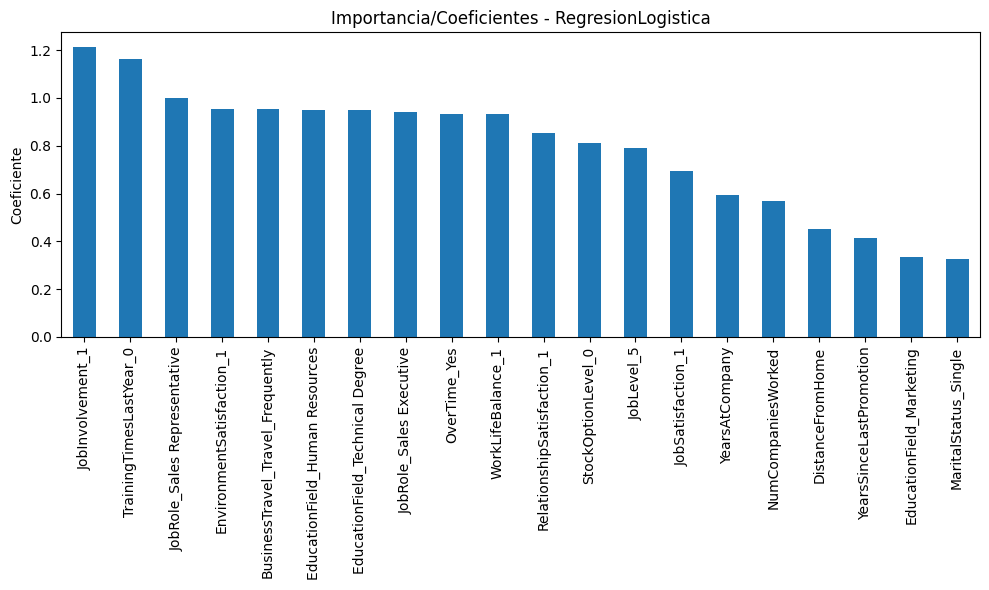

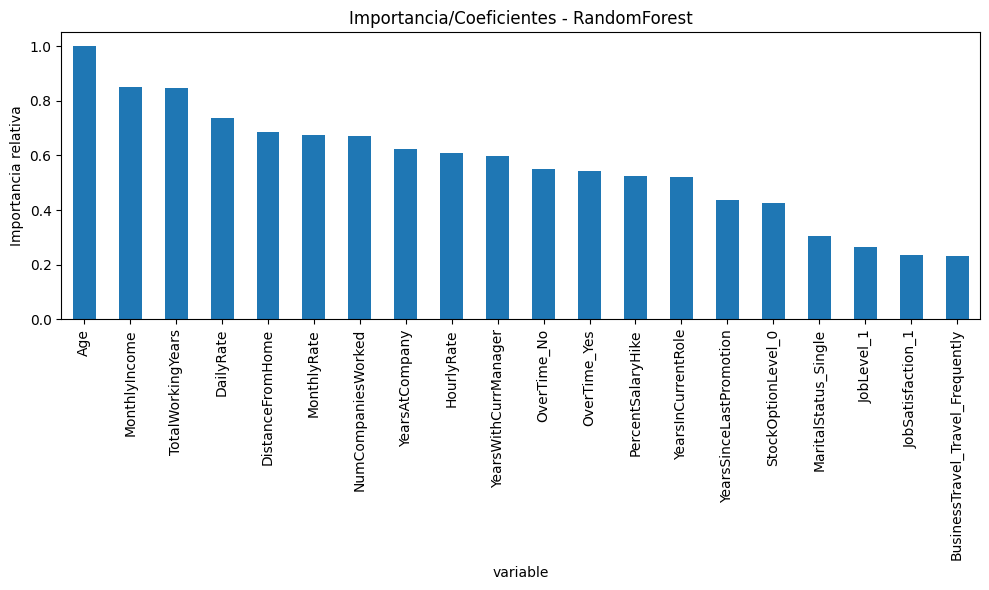

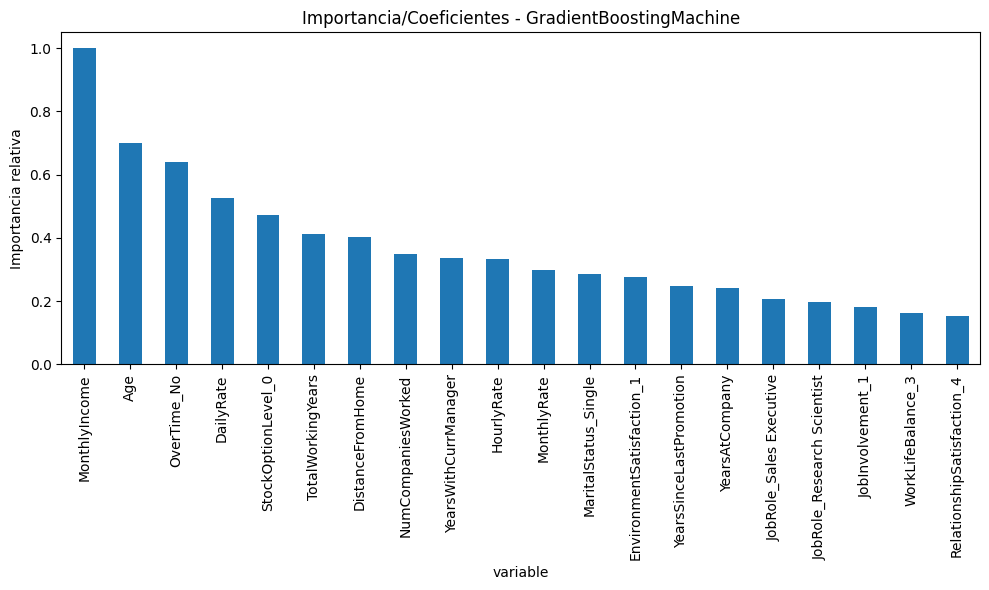

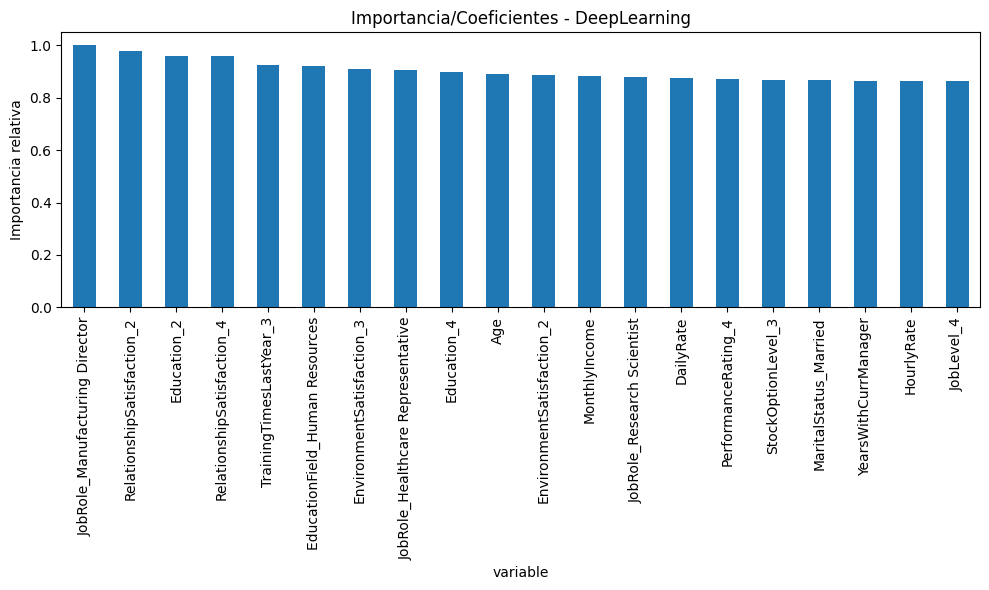

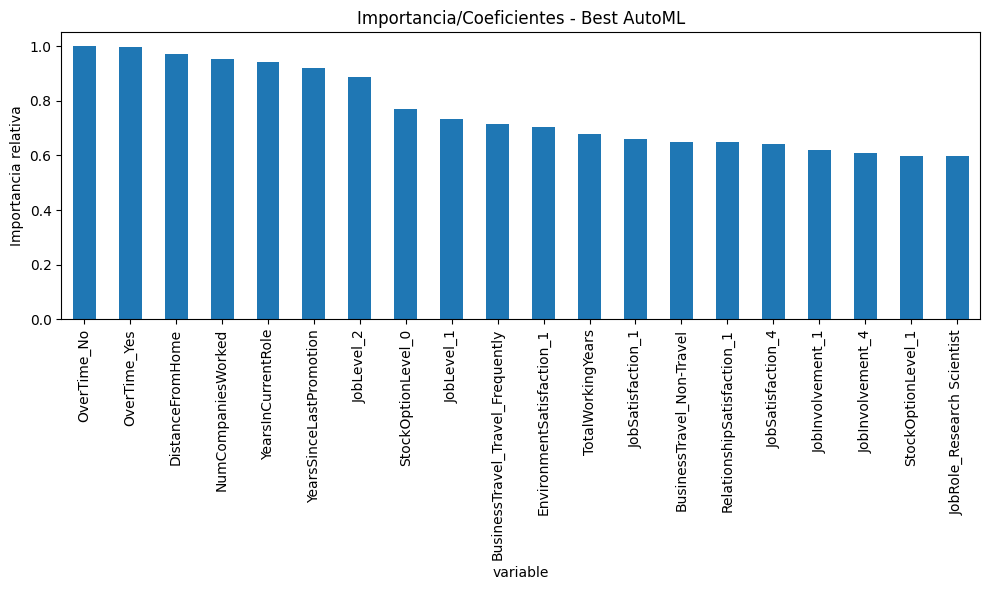

In [ ]:
for nombre, imp in importances.items():
    plt.figure(figsize=(10, 6))
    imp.sort_values(ascending=False).head(20).plot(kind='bar')
    plt.title(f"Coeficientes - {nombre}")
    plt.ylabel("Importancia" if nombre != "RegresionLogistica" else "Coeficiente")
    plt.tight_layout()
    plt.show()